In [1]:
# imports
import sys
sys.path.append( '..' )

from FIA.FIA import *
from ML.ML4com import *
from plot import *

In [71]:
run = "latent" # annot
run_dir = f"../../runs/ML/{run}"
report_dir = f"../../reports/ML"

source = "Com8_grown_together"
recon_loss = "mae_2"
project = f"{source}_{recon_loss}" if run.endswith("latent") else source

algorithms = ["Decision tree", "Extreme gradient boosting RF", "Gaussian Naive-Bayes", "K-neighbours classifier", "Linear Discriminant Analysis",
              "Logistic Regression", "Neural Network (MLP) SK-learn", "Random forest", "Support-vector classifier"]
matrices = ["metrics", "organism_metrics", "overall_metrics"]

dim_red_methods = {"Cosine": "cosine_2", "MAE": "mae_2", "MAE+Cosine": "mae_cosine_2", "Spectral Entropy": "se_2", "MSE": "mse_2", "AE+Cosine": "ae+cosine_2", "Annotated":""}

In [72]:
metrics = pd.read_csv(os.path.join(run_dir, project, f"{algorithms[0]}_{matrices[0]}.tsv"), sep="\t", index_col=0)

In [73]:
def add_methodology(df, dim_red_method:str, classification_algorithm:str):
    df["Dimensionality reduction method"] = pd.Series([dim_red_method]*len(df))
    df["Classificaton algorithm"] = pd.Series([classification_algorithm]*len(df))
    return df

In [78]:
dfs = []
for dim_red_method, recon_loss in dim_red_methods.items():
    project = source if "nnot" in dim_red_method else f"{source}_{recon_loss}"
    dr_category = "annot" if "nnot" in dim_red_method else "latent"
    for algorithm in algorithms:
        path = os.path.join("../../runs/ML/", dr_category, project, f"{algorithm}_metrics.tsv")
        dfs.append(add_methodology( pd.read_csv( path, sep="\t", index_col=0),
                                    dim_red_method=dim_red_method, classification_algorithm=algorithm))

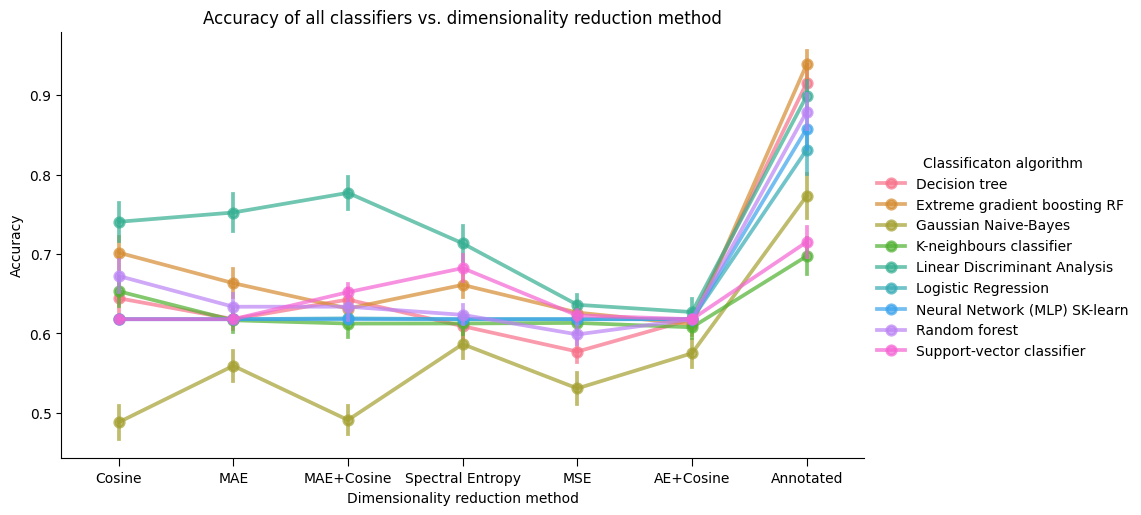

In [87]:
ax = sns.catplot(
    data=pd.concat( dfs ), x="Dimensionality reduction method", y="Accuracy", hue="Classificaton algorithm",
    kind="point", alpha=0.7, errorbar="se", palette="husl", aspect=1.8
)
ax.tick_params(axis='x', labelrotation=0, size=6)
plt.title("Accuracy of all classifiers vs. dimensionality reduction method")
plt.show()

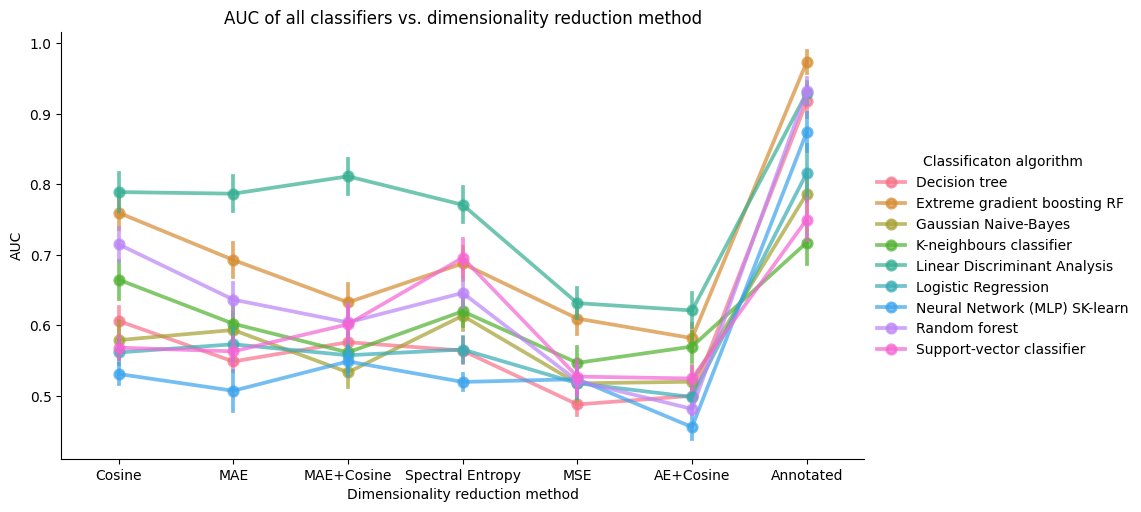

In [86]:
ax = sns.catplot(
    data=pd.concat( dfs ), x="Dimensionality reduction method", y="AUC", hue="Classificaton algorithm",
    kind="point", alpha=0.7, errorbar="se", palette="husl", aspect=1.8
)
ax.tick_params(axis='x', labelrotation=0)
plt.title("AUC of all classifiers vs. dimensionality reduction method")
plt.show()